In [1]:
# handle bugs in some docker container: 'pip install -e .'  doesn't work 
try:
    import Flamingo
except ModuleNotFoundError:
    import sys 
    sys.path.append('..')
    import Flamingo
lang_encoder_path = "facebook/opt-125m"
tokenizer_path = lang_encoder_path
cache_dir = None 
model_config = dict(
    clip_vision_encoder_path="ViT-L-14",
    clip_vision_encoder_pretrained="openai",
    lang_encoder_path=lang_encoder_path,
    tokenizer_path=tokenizer_path,
    cross_attn_every_n_layers=1,
    cache_dir = cache_dir,
    lora_tuning=False,
    decoupled=True  
)

import torch
from Flamingo.lora_tuning import create_model_and_transforms 
from Flamingo.models.batchprocessor import DecoupledFlamingoBatchProcessor
from Flamingo.datasets.gtsrb import classes
from Flamingo.config.baseline import dataset_config
from Flamingo.datasets import build_dataset
from Flamingo.inference.vis import show_pred_with_gt
import pandas as pd 
import pdb
import re


[2024-01-12 10:32:41,184] [INFO] [real_accelerator.py:161:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [2]:
# build model, image processor and tokenizer
model, image_processor, tokenizer = create_model_and_transforms(
    **model_config
)
print("Load state dict:")
state_dict = torch.load("/root/yunzhi/flamingo_retrieval/retrieval/work_dir/100/weight.pth")
keys1 = model.lang_encoder.gated_cross_attn_layers.load_state_dict(state_dict, strict=False)
keys2 = model.perceiver.load_state_dict(state_dict, strict=False)
dataset = build_dataset(
    dataset_config=dataset_config,
    vis_processor=image_processor,
    tokenizer=tokenizer)
model.eval()
batch_processor = DecoupledFlamingoBatchProcessor(cast_type='bf16', tokenizer=tokenizer)

Flamingo will use single GPU or CPU

[@rank-1|create Flamingo] create vision_encoder and image_processor from open_clip

[@rank-1|create Flamingo] create text_tokenizer

[@rank-1|create Flamingo] create LLM from  facebook/opt-125m

[@rank-1|create Flamingo] create Flamingo with cross_attn_every_n_layers= 1

[@rank-1|create Flamingo] load checkpoint.pt from huggingface

[@rank-1|create Flamingo] Freeze all parameters

[@rank-1|create Flamingo] LoRa tuning mode:  False

[@rank-1|set requires_grad] No LoRA adaptor, unfrozen the gate cross attention layer

[@rank-1|set requires_grad] unfrozen perceiver layer

Flamingo model initialized with 171MB trainable parameters

Load state dict:


In [5]:
cats = [classes[k] for k in classes]

In [6]:
def remove_special_characters(text):
    # 匹配 ASCII 特殊字符的正则表达式
    pattern = r'[^\x00-\x7f]+'
    
    # 使用空字符串替换匹配到的特殊字符
    result = re.sub(pattern, ' ', text)
    
    return result
def post_process(texts, cats=None):
    result = []
    for text in texts:
        skip_flag = False
        text = text.replace("\n", " ")
        text = remove_special_characters(text)
        if 'No passing veh over 3.5 tons' in text:
            result.append('No passing veh over 3.5 tons')    # No passing 
            continue
        if cats is not None:
            for cat in cats:
                if cat in text:
                    result.append(cat)  
                    skip_flag = True
                    # print("skip: ", cat)
                    break 
        if skip_flag:
            continue 
        # text = text.replace("\n", "")
        text = re.sub(r'guiActive.*', '', text) 
        text = re.sub(r'\\.*', '', text) 
        result.append(text)
         
    return result

In [7]:
data = dataset.random_input25()  
with torch.inference_mode():
    output = batch_processor(model=model, batch=data['vision_x'], mode='test',
            text_prompt="<image>Output:", num_beams=3, max_new_tokens=20)
    print("before post process:", output)
    output = post_process(output, cats=cats)
output

before post process: ['Output:End of speed limit (80km/h)', 'Output:Keep right', 'Output:Double curve', 'Output:Keep right', "Output:Road work guiActiveUnI'm sure it's road work guiActiveUnI'm sure it's road work", 'Output:Speed limit (100km/h)', 'Output:Ahead only', 'Output:Speed limit (50km/h)', 'Output:General caution', 'Output:Speed limit (120km/h)', 'Output:Priority road', 'Output:No passing veh over 3.5 tons', "Output:Road work guiActiveUnI'm driving now\nRoad work\nRoad work\nRoad work\nRoad work", 'Output:Speed limit (50km/h)', 'Output:Speed limit (120km/h)', 'Output:Right-of-way at intersection', 'Output:Right-of-way at intersection', 'Output:Go straight or right', 'Output:Keep right', 'Output:End no passing veh > 3.5 tons', 'Output:No passing', 'Output:Ahead only', 'Output:Speed limit (50km/h)', 'Output:Priority road', 'Output:Keep right']


['End of speed limit (80km/h)',
 'Keep right',
 'Double curve',
 'Keep right',
 'Road work',
 'Speed limit (100km/h)',
 'Ahead only',
 'Speed limit (50km/h)',
 'General caution',
 'Speed limit (120km/h)',
 'Priority road',
 'No passing veh over 3.5 tons',
 'Road work',
 'Speed limit (50km/h)',
 'Speed limit (120km/h)',
 'Right-of-way at intersection',
 'Right-of-way at intersection',
 'Go straight or right',
 'Keep right',
 'End no passing veh > 3.5 tons',
 'No passing',
 'Ahead only',
 'Speed limit (50km/h)',
 'Priority road',
 'Keep right']

In [8]:
table = pd.DataFrame({
    "pred":output,
    "gt":data['labels']
})
table

,pred,gt
0,End of speed limit (80km/h),End of speed limit (80km/h)
1,Keep right,Keep right
2,Double curve,Double curve
3,Keep right,Keep right
4,Road work,Road work
5,Speed limit (100km/h),Speed limit (100km/h)
6,Ahead only,Ahead only
7,Speed limit (50km/h),Speed limit (50km/h)
8,General caution,General caution
9,Speed limit (120km/h),Speed limit (120km/h)


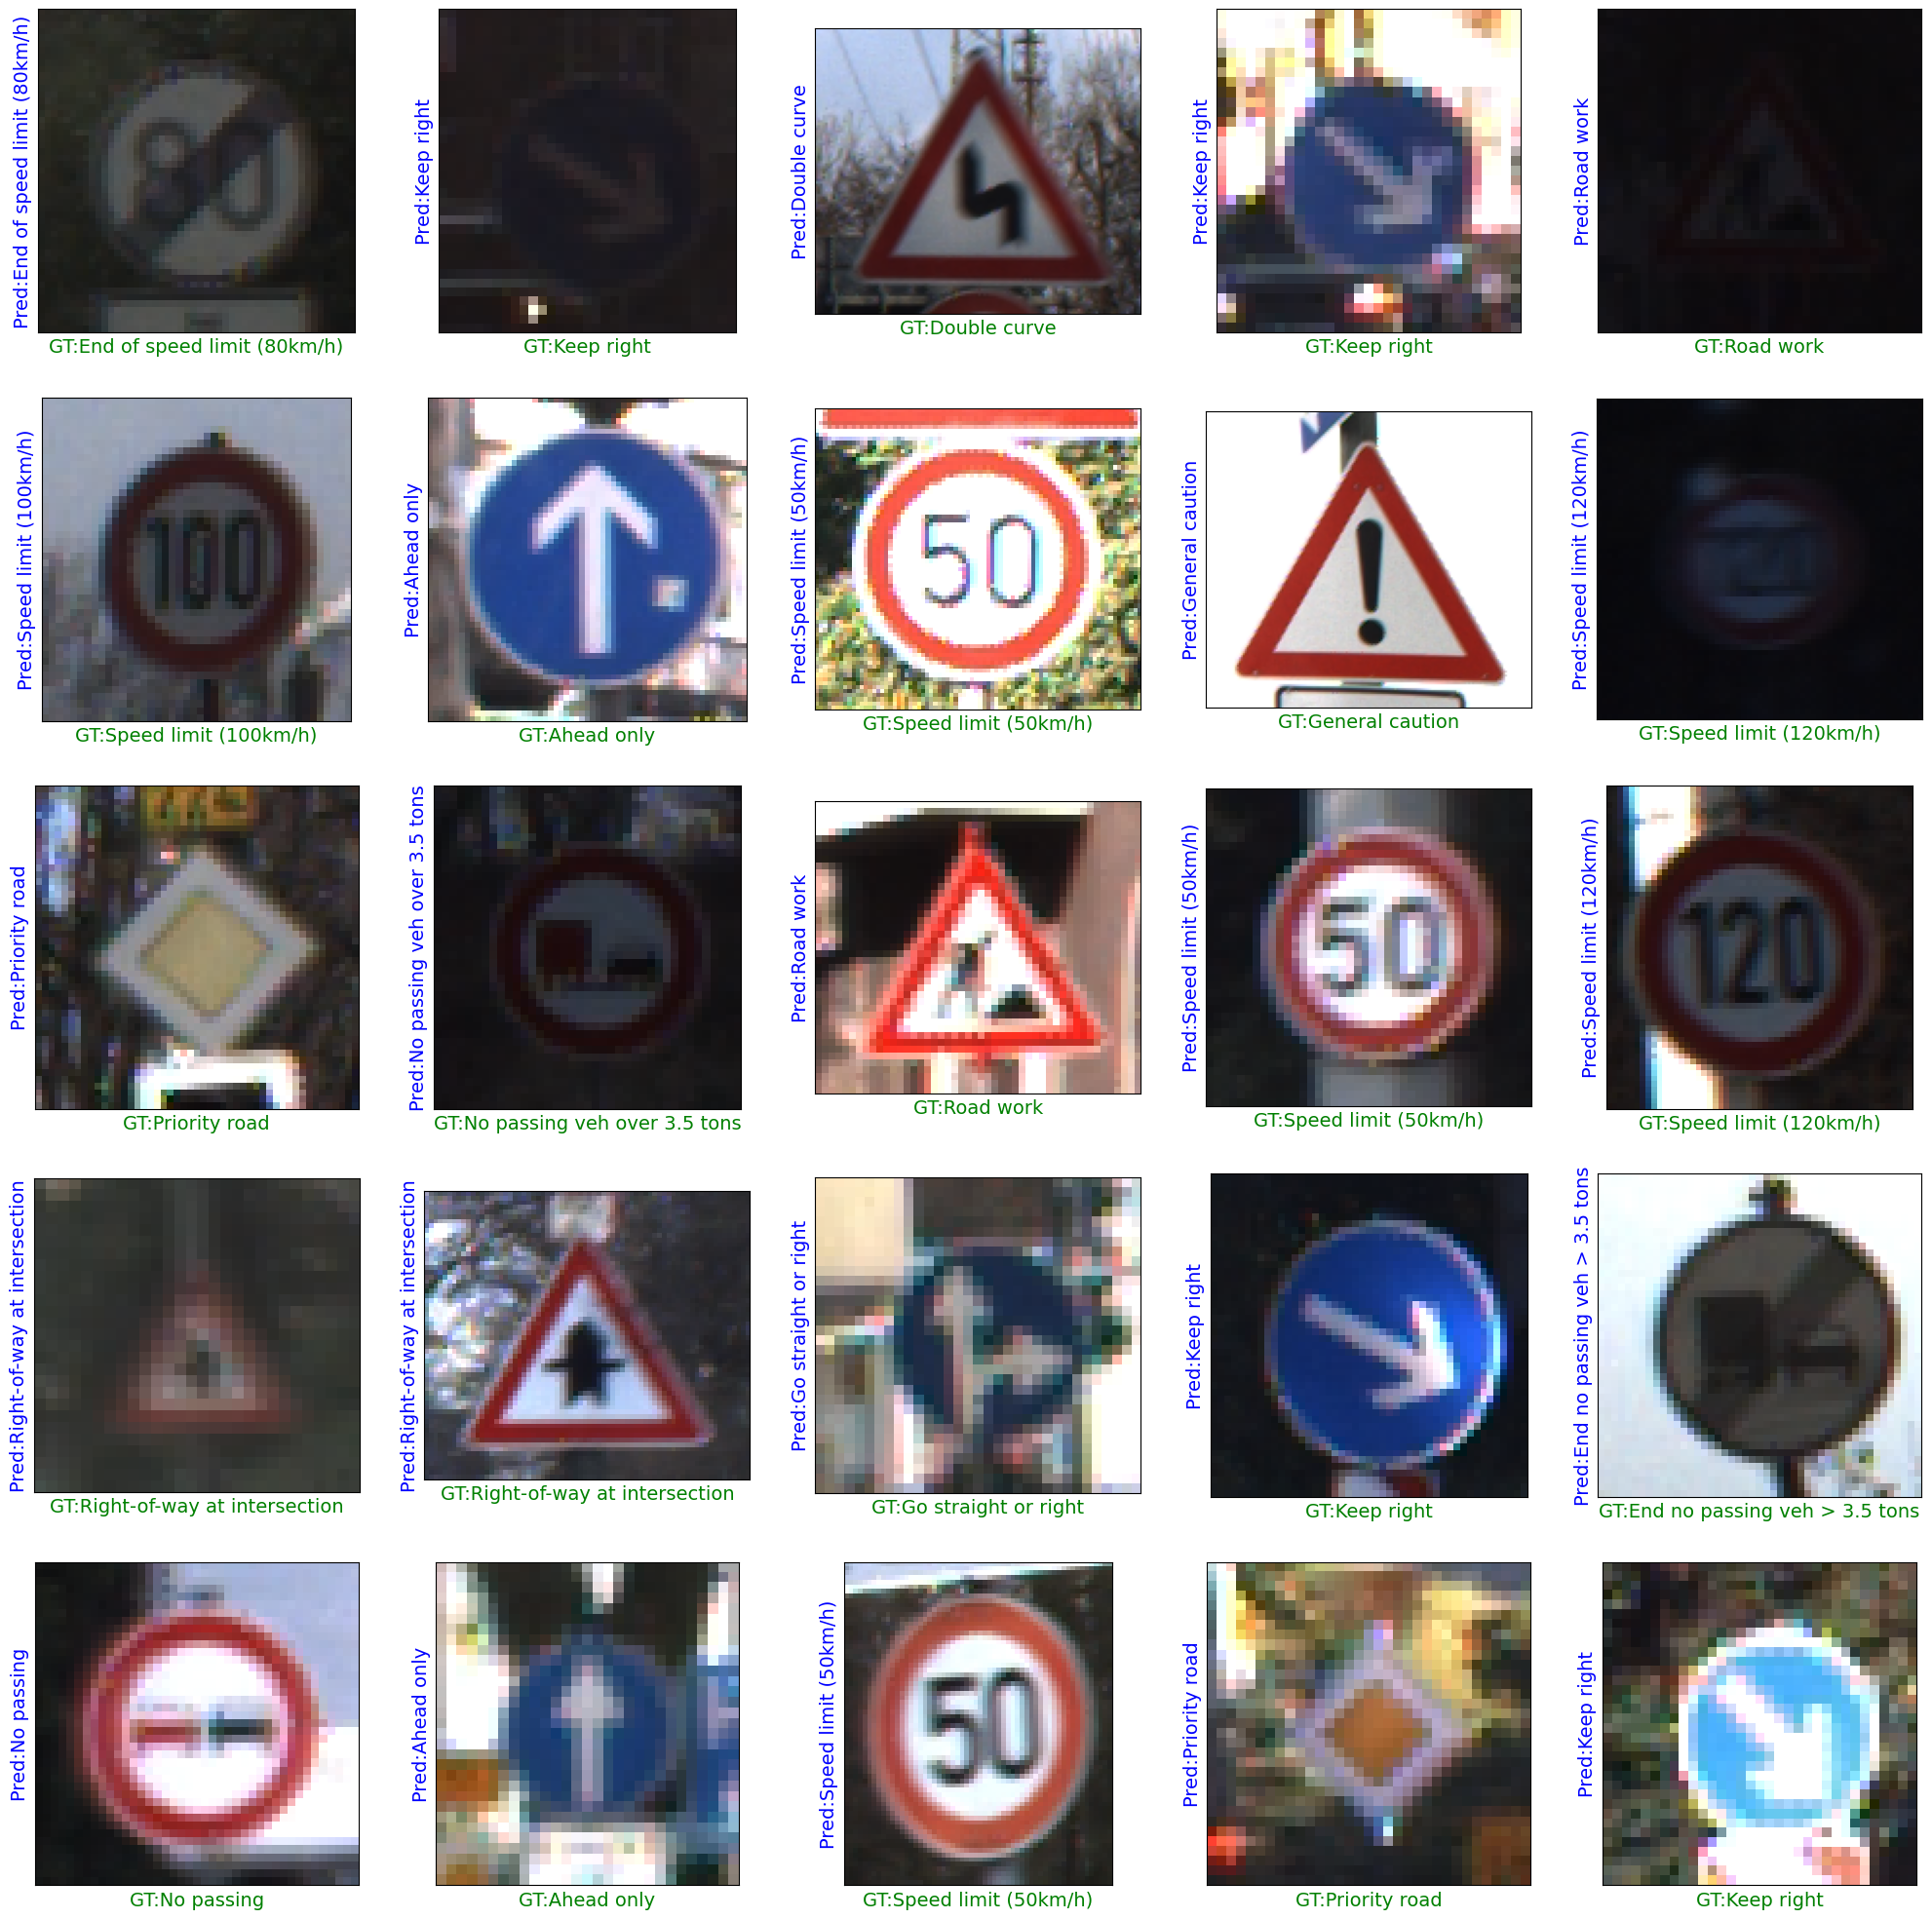

In [9]:
show_pred_with_gt(imgs=data['imgs'], preds=output, gts=data['labels'])

In [10]:
""" 
see training log:
loss is close to 0
"""
!tail -n 20 /root/yunzhi/flamingo_retrieval/retrieval/work_dir/[2024-01-10][22:54:19]PID:64834.log

2024-01-11 06:37:27.622 | INFO     | Flamingo.runner.deepspeed_runner:info_rank_zero:145 - [rank@0|4][Epoch:100|100][Step:230|409] Dataset: GTSRB, Loss: 8.940696716308594e-07
2024-01-11 06:37:34.273 | INFO     | Flamingo.runner.deepspeed_runner:info_rank_zero:145 - [rank@0|4][Epoch:100|100][Step:240|409] Dataset: GTSRB, Loss: 6.109476089477539e-07
2024-01-11 06:37:40.628 | INFO     | Flamingo.runner.deepspeed_runner:info_rank_zero:145 - [rank@0|4][Epoch:100|100][Step:250|409] Dataset: GTSRB, Loss: 6.966292858123779e-07
2024-01-11 06:37:47.428 | INFO     | Flamingo.runner.deepspeed_runner:info_rank_zero:145 - [rank@0|4][Epoch:100|100][Step:260|409] Dataset: GTSRB, Loss: 2.9616057872772217e-07
2024-01-11 06:37:54.189 | INFO     | Flamingo.runner.deepspeed_runner:info_rank_zero:145 - [rank@0|4][Epoch:100|100][Step:270|409] Dataset: GTSRB, Loss: 7.636845111846924e-07
2024-01-11 06:38:01.352 | INFO     | Flamingo.runner.deepspeed_runner:info_rank_zero:145 - [rank@0|4][Epoch:100|100][Step:28

In [ ]:
import sentence_transformers
output[14],data['labels'][1]